<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/LHMProgram/blob/main/Ana_Alonso_LMHSS23_AAI_Week1_Ex1_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using the CIFAR10 data provided below, create an alogrithm that takes in a gray scale image and coverts it to a color image.

Note for this problem we will define the grayscale image as the average of the three color channels.

In [1]:
# Import libraries
from torchvision.datasets import CIFAR10
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

from matplotlib import pyplot as plt

In [2]:
# Download the data
train_data = CIFAR10(root='./datasets', train=True, download=True)
test_data = CIFAR10(root='./datasets', train=True, download=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 28889916.50it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


In [4]:
img=train_data[0][0]
rgb_img=np.asarray(img)
gray_img=np.average(rgb_img,axis=-1)
print(f"\n The shape of the RGB images: {rgb_img.shape} The shape of the gray scale images: {gray_img.shape}\n")


 The shape of the RGB images: (32, 32, 3) The shape of the gray scale images: (32, 32)



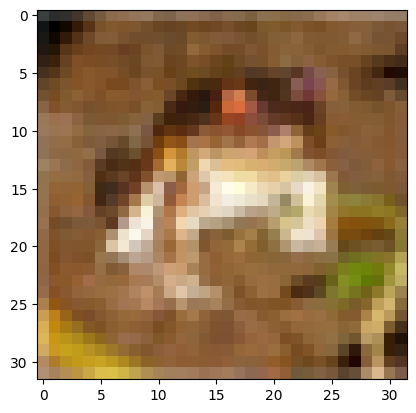

In [5]:
# RGB Image show
plt.imshow(rgb_img)
plt.show()

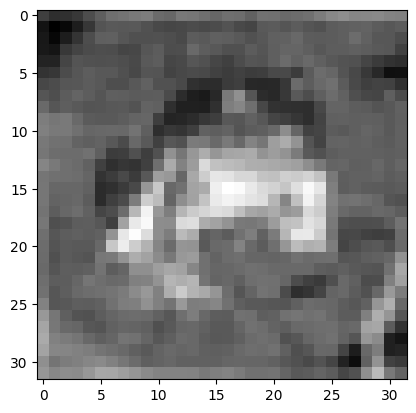

In [6]:
# Gray scale Image show
plt.imshow(gray_img,cmap='gray')
plt.show()

In [7]:
# Handeling the data from the CIFAR10 format (32x32)
# Taking CIFAR10 data and returning 2 tensors

class Cifar_dataset(Dataset):
    def __init__(self,data):
        self.data=data

    def __len__(self):
        return len(self.data)

    # Creating 2 tensors with the rgb and gray scale images
    def __getitem__(self, idx):
      rgb_img=np.asarray(self.data[idx][0])
      gray_img=np.average(rgb_img,axis=-1)
      rgb_img=rgb_img.reshape(-1,32,32)
      gray_img=gray_img.reshape(-1,32,32)

      return torch.tensor(gray_img,dtype=float),torch.tensor(rgb_img,dtype=float)

In [8]:
# Preparing the dataset for training and testing in a DataLoader, to load and batching of data during the training and testing process

train_dataset=Cifar_dataset(train_data)
test_dataset=Cifar_dataset(test_data)

# I am using the pin_memory=True to transfer the data to the GPU's pinned memory, making the process faster.
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=64, shuffle=False, pin_memory=True)

In [9]:
# After asking for help, I chose to use Residual convolutionak blocks, because it
# allows an efficient training of very deep networks and mitigates the vanishing gradient problem.

class ResConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResConvBlock, self).__init__()

        # The main part of the model consists of 2 convolutional layers followed by batchNorm and using the ReLU activation.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If the dims of the input and the output of the main part are not equal,
        # another connection will be created with a convolutional layer and a batchNorm
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    # Forward pass. Conv layer, batchNorm and relu activation, the 'out' tensor
    # then passes a 2nd conv layer and another batchNorm. The tensor to the shortcut connection.
    #  Finally, Relu its applied to the tensor that will be returned.
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [14]:
# Class with functions consisting of a series of encoder blocks followed by the
# corresponding decoder blocks to compress and then reconstruct the input data.

class Encoder_decoder(nn.Module):
    # It takes 1 channel = gray scale and has 3 output channels = RGB
    def __init__(self, in_channels=1, out_channels=3):
        super(Encoder_decoder, self).__init__()

        # Encoder. Using max pooling to reduce the dimensions by half.
        self.encoder1 = ResConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.encoder2 = ResConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.encoder3 = ResConvBlock(128, 256)

        # Decoder. Reconstruction, opposite as the encoder. The upsample increases the dimension by 2.
        self.decoder1 = ResConvBlock(256, 128)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.decoder2 = ResConvBlock(256, 64)
        self.upsample2 = nn.Upsample(scale_factor=2)
        # Last layer of the decoder, a convolutional layer
        self.decoder3 = nn.Conv2d(128, out_channels, kernel_size=1)

    # Forward pass for the encoding decoding part.
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        dec2 = self.upsample1(self.decoder1(enc3))
        dec1 = self.upsample2(self.decoder2(torch.cat((dec2, enc2), dim=1)))

        # The output of the dec2 is concatenated with the output of the enc1 block and passed through the decoder3 layer
        return self.decoder3(torch.cat((dec1, enc1), dim=1))

In [15]:
# Set the hyperparameters
num_epochs = 50
learning_rate = 0.01

# Model, Loss calculate using Mean Square Error and Adam Optimizer
model = Encoder_decoder().cuda()  # Move model to GPU memory
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    Training_loss=0
    model.train()  # Set model to training mode
    # Iterates over the train_loader batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to GPU memory
        data, target = data.float().cuda(), target.float().cuda()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass computing the gradients of the loss, updating the model's
        # parameters and accumulating the training loss for each epoch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        Training_loss+=loss.item()

    # Validation
    model.eval()  # Set model to evaluation mode
    validation_loss = 0
    with torch.no_grad():
        # Iterates over the test_loader batches
        for data, target in test_loader:
            data, target = data.float().cuda(), target.float().cuda()
            output = model(data)
            validation_loss += criterion(output, target).item()  # Adding the batch loss

    # Average of the trainning and testing loss
    validation_loss /= len(test_loader)
    Training_loss /= len(train_loader)
    print(f"\n Training set average Loss: {Training_loss} Validation set average loss: {validation_loss:.4f}\n")


 Training set Loss: 2562.865674889606 Validation set: Average loss: 1710.7569


 Training set Loss: 1660.740624000959 Validation set: Average loss: 1622.9590


 Training set Loss: 1610.545174757233 Validation set: Average loss: 1581.9810


 Training set Loss: 1581.4604790338774 Validation set: Average loss: 1579.0760


 Training set Loss: 1564.0134024461518 Validation set: Average loss: 1546.7169


 Training set Loss: 1560.446305296915 Validation set: Average loss: 1536.9849


 Training set Loss: 1546.8306105825907 Validation set: Average loss: 1541.3498


 Training set Loss: 1539.5878836004936 Validation set: Average loss: 1576.2318


 Training set Loss: 1533.370580492727 Validation set: Average loss: 1575.0918


 Training set Loss: 1528.3458484542339 Validation set: Average loss: 1513.8313


 Training set Loss: 1522.087276370934 Validation set: Average loss: 1517.1754


 Training set Loss: 1515.0041828594549 Validation set: Average loss: 1573.1042


 Training set Loss: 1509.02030410

In [16]:
# The first image sample from the test_data dataset
img=test_data[0][0]
img

In [27]:
# RGB tensor conversion to numpy array, gray scale and then to a tensor with 1 channel
rgb_img=np.asarray(img)
gray_img=np.average(rgb_img,axis=-1)
input=torch.tensor(gray_img).float().view(1,1,32,32).cuda()

# Calling the model with the input, reshaped in (32x32x3) dim and detached cause
# there is no need more gradient calculation
output=model(input)
output=output.view(32,32,3).cpu()
output=output.detach().numpy()

Text(0.5, 1.0, 'RGB Image')

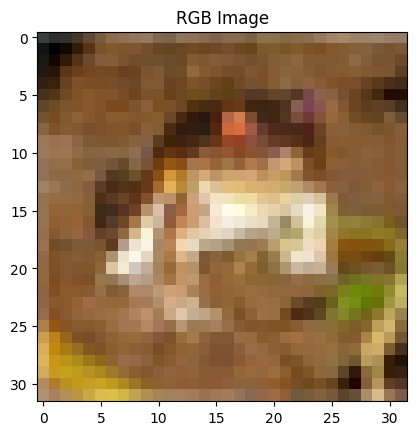

In [24]:
plt.imshow(rgb_img)
plt.title('RGB Image')

Text(0.5, 1.0, 'Gray Image')

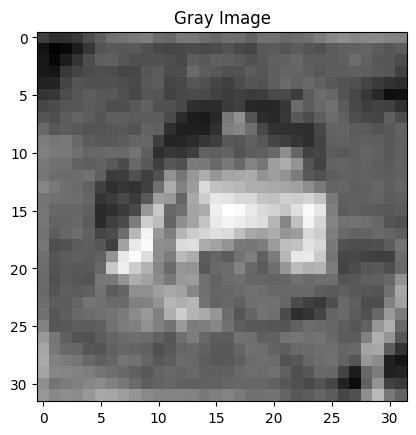

In [25]:
plt.imshow(gray_img,cmap='gray')
plt.title('Gray Image')

Text(0.5, 1.0, 'Predicted RGB Image')

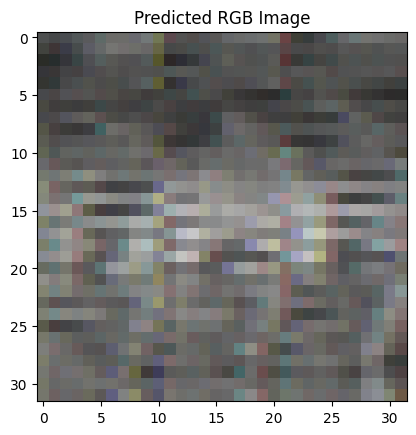

In [26]:
# Integer conversion and shown of the test image
output=output.astype(int)

plt.imshow(output)
plt.title('Predicted RGB Image')